马科维茨模型（Markowitz Model）
====

By solving the markowitz model, we can get the optimal asset allocation (w, wf) for each period of position adjustment. We only need to adjust the position to the optimal allocation ratio at the starting point of each position adjustment cycle.

The pseudo code of the policy is as follows:
Step 0: Initialize parameters. Specify the frequency of position adjustment (takes T=30, that is, 30 trading days as the period of position adjustment), and set the optimization objective function of each cycle model (sets the objective function as Sharp ratio). Specify t=0, enter Step 1;

Step 1: On the current position adjustment date, calculate the daily return rate ri, t and daily volatility of various assets based on the daily closing price of the previous cycle, and bring it into Markowitz model to generate various asset target weights wi, t;

Step 2: Adjust the proportion of various assets to the target weight based on the closing price of the day;

Step 3: Make t=t+1, and repeat Step 1 until the end of backtesting.

In [1]:
from WindPy import *
import numpy as np
import pandas as pd
from datetime import *
import talib as ta
import matplotlib.pyplot as plt
from numpy import roots
import math
from scipy import stats
from scipy.optimize import minimize

import datetime
from openpyxl.reader.excel import load_workbook as lw
import pymysql
from pylab import *
from matplotlib.font_manager import FontProperties  
%matplotlib inline
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
#数据导入
path = "C:/Users/DELL/Desktop/策略代码/data_eb2.xlsx"
data = pd.read_excel(path) #读取数据
data.set_index(data["time"], inplace=True) #设置数据索引为交易日

HS300ETF = pd.DataFrame(data[data["code"] == '510310.SH']["close"].astype(float)) #沪深300ETF专属数据结构。仅保留收盘价格
GZ5yETF = pd.DataFrame(data[data["code"] == '511010.SH']["close"].astype(float)) #国债ETF专属数据结构。仅保留收盘价格

td_dates = HS300ETF.index #记录交易日信息，方便以后进行查找
n = len(td_dates) #记录回溯交易日天数

data.set_index(data["time"], inplace=True) #设置数据索引为交易日
tickers = ["510310.SH","511010.SH","518880.SH",'131801.SZ']

HS300ETF = pd.DataFrame(data[data["code"] == '510310.SH']["close"].astype(float)) #沪深300ETF专属数据结构。仅保留收盘价格
GZ5yETF = pd.DataFrame(data[data["code"] == '511010.SH']["close"].astype(float)) #国债ETF专属数据结构。仅保留收盘价格
GoldETF = pd.DataFrame(data[data["code"] == '518880.SH']["close"].astype(float)) #黄金ETF专属数据结构。仅保留收盘价格
R_001 = pd.DataFrame(data[data["code"] == '131801.SZ']["close"].astype(float)) #黄金ETF专属数据结构。仅保留收盘价格

td_dates = HS300ETF.index #记录交易日信息，方便以后进行查找
n = len(td_dates)

In [4]:
#######################
## Module2: 计算收益率 ##
#######################
pd.set_option('mode.chained_assignment', None)

# 创建收益率序列
HS300ETF['RETURN'] = 0 #创建收益率序列
GZ5yETF['RETURN'] = 0 #创建收益率序列
GoldETF['RETURN'] = 0 #创建收益率序列
R_001['RETURN'] = 0
HS300ETF['RETURN'].astype(float)#设定格式为浮点
GZ5yETF['RETURN'].astype(float)#设定格式为浮点
GoldETF['RETURN'].astype(float)#设定格式为浮点
R_001['RETURN'].astype(float)#设定格式为浮点

# 计算收益率
HS300ETF["RETURN"][td_dates[1:]] = np.array(HS300ETF["close"][td_dates[1:]]) / np.array(HS300ETF["close"][td_dates[:-1]]) - 1 #计算HS300ETF日收益率
GZ5yETF["RETURN"][td_dates[1:]] = np.array(GZ5yETF["close"][td_dates[1:]]) / np.array(GZ5yETF["close"][td_dates[:-1]]) - 1 #计算GZ5yETF日收益率
GoldETF["RETURN"][td_dates[1:]] = np.array(GoldETF["close"][td_dates[1:]]) / np.array(GoldETF["close"][td_dates[:-1]]) - 1 #计算GZ5yETF日收益率
R_001["RETURN"][td_dates[1:]] = np.array(R_001["close"][td_dates[1:]])/100/365

# 将收益率序列单独存储至returns
returns = pd.DataFrame({'510310.SH':HS300ETF["RETURN"], '511010.SH':GZ5yETF["RETURN"], '518880.SH':GoldETF["RETURN"], '131801.SZ':R_001["RETURN"]},
                       index= td_dates)

#print(returns.head())  #打印表头查看


In [5]:
import Mean_Variance as MV

In [6]:
#################################
## Module 3: 计算策略权重    ######
#################################
def weights_calculate_MV(T):
    weights_strategy_MV = []
    for t in range(T, n, T):
        R = []
        for i in range(3):
            R.append(np.mean(returns[tickers[i]][td_dates[t - T:t]]) * T)
        rf = np.mean(returns['131801.SZ'][td_dates[t - T:t]]) * T
        Sigma = np.cov(returns[tickers[0:3]][t - T:t] * T, rowvar=False)
        outcome = MV.M_V(R=R, rf=rf, Sigma=Sigma)
        for i in range(T):
            weights_strategy_MV.append(outcome['Weights'])

    return weights_strategy_MV



#################################
## Module 4: 各策略净值与收益率计算 ##
#################################
nv_HS300ETF = [1]  #记录全仓股票策略净值
nv_GZ5yETF = [1]  #记录全仓债券策略净值
nv_GoldETF = [1]
nv_Cash = [1]
r_HS300ETF = []
r_GZ5yETF = []
r_GoldETF = []
r_Cash = []
nv_strategy_MV = [1]
r_strategy_MV = []


T = 30 #设置调仓/回看窗口期（以30天为例）
weights_strategy_MV = weights_calculate_MV(T)

for i in range(T, n):
    nv_HS300ETF.append( nv_HS300ETF[i-T] *(1 + returns['510310.SH'][td_dates[i]]))
    nv_GZ5yETF.append( nv_GZ5yETF[i-T] *(1 + returns['511010.SH'][td_dates[i]]))
    nv_GoldETF.append( nv_GoldETF[i-T] *(1 + returns['518880.SH'][td_dates[i]]))
    nv_Cash.append( nv_Cash[i-T] *(1 + returns['131801.SZ'][td_dates[i]]))
    r_HS300ETF.append(returns['510310.SH'][td_dates[i]])
    r_GZ5yETF.append(returns['511010.SH'][td_dates[i]])
    r_GoldETF.append(returns['518880.SH'][td_dates[i]])
    r_Cash.append(returns['131801.SZ'][td_dates[i]])
    if i >= T:
        r_strategy_MV.append(weights_strategy_MV[i - T][0] * returns[tickers[0]][td_dates[i]] +
                         weights_strategy_MV[i - T][1] * returns[tickers[1]][td_dates[i]] +
                         weights_strategy_MV[i - T][2] * returns[tickers[2]][td_dates[i]] +
                         weights_strategy_MV[i - T][3] * returns[tickers[3]][td_dates[i]])
    else:
        r_strategy_MV.append(0)
    nv_strategy_MV.append(nv_strategy_MV[i-T] * (1 + r_strategy_MV[i-T]))

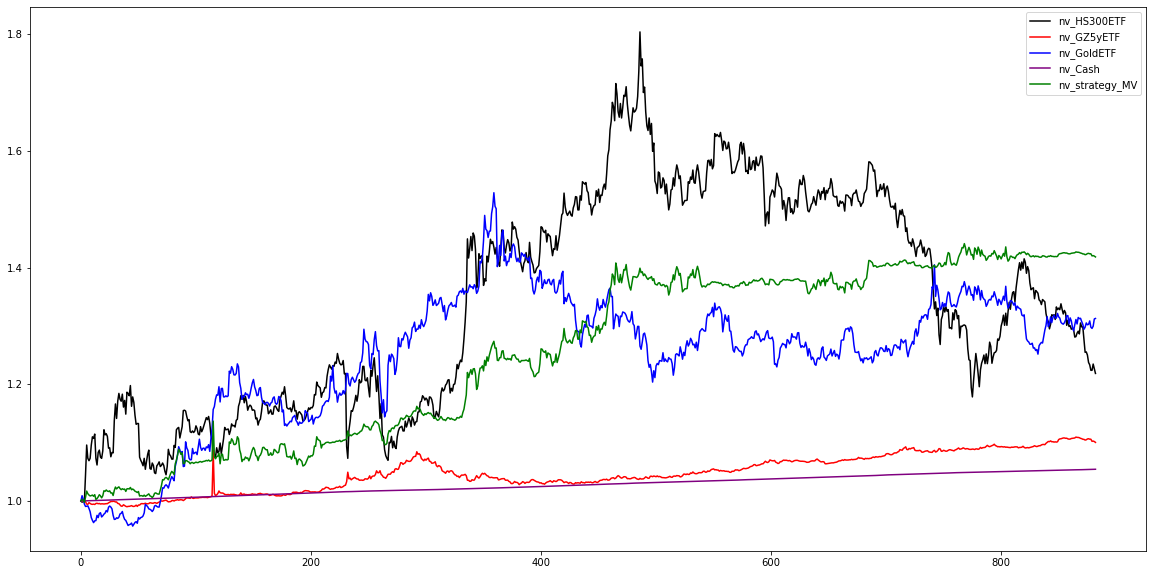

In [9]:
################################
## Module 6: 绘制各策略净值走势图 ##
################################
plt.figure(figsize=(20, 10))
plt.plot(nv_HS300ETF, label = "nv_HS300ETF", color = "black")
plt.plot(nv_GZ5yETF, label = "nv_GZ5yETF", color = "red")
plt.plot(nv_GoldETF, label = "nv_GoldETF", color = "blue")
plt.plot(nv_Cash, label="nv_Cash", color="purple")
plt.plot(nv_strategy_MV, label="nv_strategy_MV", color="green")
plt.legend()
plt.show()